In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.exceptions import ConvergenceWarning
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import RegexpTokenizer
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hanxingsharpayyu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hanxingsharpayyu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/hanxingsharpayyu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Part 1
## Data Pre-Processing

In [2]:
df = pd.read_csv('sentiment_analysis.csv')
df.head()

,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1


In [3]:
# regex search a string for pattern
# remove any urls (anything that starts with http and ends with non-whitespace character)
# remove any word character that's not [a-zA-Z0-9_] and whitespace

def clean_file_text(text):
    new_text = re.sub(r'http\S+', '', text) 
    new_text = re.sub(r'[^\w\s]', '', new_text)
    return new_text

In [4]:
# To separate a sentence into words without puctuation, we use RegexpTokenizer(r'\w+') as our tokenizer. 
# stop word (frequently used word that has little to no additional meanings), remove them to focus on the context

# Porter stemmer accepts the list of tokenzied words and stems them into root words (cutting the suffix from the word)
# lemma: the most basic form of a word
# lemmatization finds the lemma of a word depending on the context and meaning

def data_preprocess(text):
  tokenizer = RegexpTokenizer(r'\w+') 
  stop_words = set(stopwords.words('english'))
  ps = PorterStemmer()
  lemmatizer = WordNetLemmatizer()
  
  file_data = clean_file_text(text)
  file_data = file_data.lower()
  file_data = clean_file_text(file_data)
  file_words = tokenizer.tokenize(file_data)
  file_words = [w for w in file_words if not w.lower() in stop_words]
  file_words = [ps.stem(w) for w in file_words] # loop over to find the root words
  file_words = [lemmatizer.lemmatize(w) for w in file_words]
  return file_words

In [5]:
def corpus_count_words(text, num_words):
    word_counter = Counter()
    for words in text:
      word_counter.update(words)
    word_list = [word for (word, freq) in word_counter.most_common(num_words)]

    df_rows = []
    for words in text:
      row = [1 if word in words else 0 for word in word_list]
      df_rows.append(row)

    X = pd.DataFrame(df_rows, columns = word_list)
    return X

In [6]:
X = corpus_count_words(df['text'].apply(data_preprocess), 100)

In [7]:
X

,rt,love,happi,thank,great,good,im,day,best,amaz,...,right,everyon,bless,think,thanksgiv,babi,tri,help,well,hate
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550386,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
550387,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
550388,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
550389,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# label of sentiment from the original dataset, 1 = positive, 0 = negative
df['label']

0         1
1         1
2         1
3         1
4         1
         ..
550386    0
550387    0
550388    1
550389    1
550390    1
Name: label, Length: 550391, dtype: int64

In [9]:
# 70% for training
X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size=0.3, random_state=42)

## Logistic Refression
Logistic regression is chosen as the first model as the sentiment analysis is a binary classification problem

In [10]:
clf = LogisticRegression().fit(X_train, y_train)
# predict on train and test set
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)
# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)

/Users/hanxingsharpayyu/opt/anaconda3/envs/pearl1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
print(train_accuracy, test_accuracy)

0.8623469591692124 0.8623469276517399


With gridsearchCV and Cross-Validation

In [12]:
parameters = {'C':[0.01, 0.1, 1, 10, 100], 
              'solver':('liblinear','lbfgs', 'newton-cg'),
              'penalty':('none',  'l2')}

model = LogisticRegression()
cv = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
cv.fit(X_train, y_train)

print('Best cross-validation score is :\n',cv.best_score_)
print('Best parameter:\n', cv.best_params_)

/Users/hanxingsharpayyu/opt/anaconda3/envs/pearl1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/hanxingsharpayyu/opt/anaconda3/envs/pearl1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/hanxingsharpayyu/opt/anaconda3/envs/pearl1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/hanxingsharpayyu/opt/anaconda3/envs/pearl1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/hanxingsharpayyu/opt/anaconda

Best cross-validation score is :
 0.8620951865199586
Best parameter:
 {'C': 0.01, 'penalty': 'none', 'solver': 'lbfgs'}


/Users/hanxingsharpayyu/opt/anaconda3/envs/pearl1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
# best logsitic regression model
# results varies bewtween runs
bestLOGmodel = LogisticRegression(C = 10, penalty= 'l2', solver = 'lbfgs')
bestLOGmodel.fit(X_train, y_train)
y_pred_LOG = bestLOGmodel.predict(X_test)
LOG_f1 = f1_score(y_test, y_pred_LOG)
LOG_acc = accuracy_score(y_test, y_pred_LOG)
print("F1 Score SVM:",LOG_f1)
print("Accuracy Score SVM:",LOG_acc)

/Users/hanxingsharpayyu/opt/anaconda3/envs/pearl1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


F1 Score SVM: 0.8933530419276883
Accuracy Score SVM: 0.8623590402015529


## Naive Bayes
Naive Bayes is one of the fastest, simplest classification algorithms, yet well suitabed for large dataset, and has proven effectiveness in sentiment analysis and other NLP classification problems. Bernourlli Naive Bayes takes binary values as input (X). 

In [14]:
clf = BernoulliNB().fit(X_train, y_train)
# predict on train and test set
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)
# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)
test_f1 = f1_score(y_test, y_test_predict)
print("F1 Score NB:",test_f1)
print("Accuracy Score NB:",test_accuracy)

F1 Score NB: 0.8907675543899827
Accuracy Score NB: 0.856720648263666


### SVM
Since X has 550,391 features, SVM has proven to be effecting in handling larger feature spaces and generalizing in high dimensional feature spaces. SVM eliminates the requirement of feature selection and can handle irrelevant features (since most of the features are irrelevant in text categorization).

With gridsearchCV and Cross-Validation

In [15]:
parameters = {'C':[0.001, 0.01, 0.1, 1, 10]}
model = LinearSVC(random_state=0, tol=1e-5)
cv = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
cv.fit(X_train, y_train)

print('The best cross-validation score: ',cv.best_score_)
print('The best parameter:', cv.best_params_)

/Users/hanxingsharpayyu/opt/anaconda3/envs/pearl1/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hanxingsharpayyu/opt/anaconda3/envs/pearl1/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hanxingsharpayyu/opt/anaconda3/envs/pearl1/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hanxingsharpayyu/opt/anaconda3/envs/pearl1/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hanxingsharpayyu/opt/anaconda3/envs/pearl1/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the

The best cross-validation score:  0.861236053656701
The best parameter: {'C': 0.01}


In [16]:
bestSVMmodel = LinearSVC(random_state=0, tol=1e-5, C = 0.01)
bestSVMmodel.fit(X_train, y_train)
y_pred_SVM = bestSVMmodel.predict(X_test)
SVM_f1 = f1_score(y_test, y_pred_SVM)
SVM_acc = accuracy_score(y_test, y_pred_SVM)
print("F1 Score SVM:",SVM_f1)
print("Accuracy Score SVM:",SVM_acc)


F1 Score SVM: 0.8922430876663205
Accuracy Score SVM: 0.861686793686939


### Random Forest


In [17]:
parameters = {'min_samples_split':[3, 5, 10, 15, 20],
              'n_estimators':[10, 50, 100, 200]}

model = RandomForestClassifier( random_state=0)
cv = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
cv.fit(X_train, y_train)

print('The best cross-validation score: ',cv.best_score_)
print('The best parameter:', cv.best_params_)

The best cross-validation score:  0.8680961270972803
The best parameter: {'min_samples_split': 15, 'n_estimators': 200}


In [22]:
model.decision_path

<bound method BaseForest.decision_path of RandomForestClassifier(random_state=0)>

Get accuracy and f1 socre on test set using the best RF model (with 200 trees)

In [18]:
bestRFmodel = RandomForestClassifier(min_samples_split = 15, n_estimators= 200, random_state=0)
bestRFmodel.fit(X_train, y_train)
y_pred_RF = bestRFmodel.predict(X_test)
RF_f1 = f1_score(y_test, y_pred_RF)
RF_acc = accuracy_score(y_test, y_pred_RF)
print("F1 Score Random Forest:",RF_f1)
print("Accuracy Score Random Forest:",RF_acc)


F1 Score Random Forest: 0.8988183986879381
Accuracy Score Random Forest: 0.8684819341319541


Result Summary for part1

In [19]:
model_list = ['Logistic Regression', 'Naive Bayes', 'SVM', 'Random Forest']
f1_list = [LOG_f1, test_f1, SVM_f1, RF_f1]
acc_list = [LOG_acc, test_accuracy,SVM_acc, RF_acc]

In [20]:
result_df = pd.DataFrame({
    'Model': model_list,
    'F1 Score': f1_list,
    'Accuracy': acc_list
})
result_df

,Model,F1 Score,Accuracy
0,Logistic Regression,0.893353,0.862359
1,Naive Bayes,0.890768,0.856721
2,SVM,0.892243,0.861687
3,Random Forest,0.898818,0.868482


Based on F1 socre, Random Forest model with min_sample_split = 15, and 200 n_estimators performed the best, this model will be used in part 2.

[Text(0.9256662052596587, 0.9949494949494949, 'love <= 0.5\ngini = 0.438\nsamples = 243615\nvalue = [124778, 260495]'),
 Text(0.8576516837105976, 0.9848484848484849, 'beauti <= 0.5\ngini = 0.461\nsamples = 216885\nvalue = [123736, 218894]'),
 Text(0.7936407452329818, 0.9747474747474747, 'rt <= 0.5\ngini = 0.467\nsamples = 210284\nvalue = [123395, 208762]'),
 Text(0.6978143844718486, 0.9646464646464646, 'found <= 0.5\ngini = 0.483\nsamples = 169549\nvalue = [109597, 158278]'),
 Text(0.673952265812479, 0.9545454545454546, 'dont <= 0.5\ngini = 0.489\nsamples = 162406\nvalue = [109043, 147587]'),
 Text(0.6347270494574111, 0.9444444444444444, 'today <= 0.5\ngini = 0.484\nsamples = 156647\nvalue = [101961, 145538]'),
 Text(0.6121915946301412, 0.9343434343434344, 'thank <= 0.5\ngini = 0.486\nsamples = 152575\nvalue = [100619, 140428]'),
 Text(0.5952021229528071, 0.9242424242424242, 'bad <= 0.5\ngini = 0.494\nsamples = 142853\nvalue = [100453, 125355]'),
 Text(0.5853230866224931, 0.91414141414

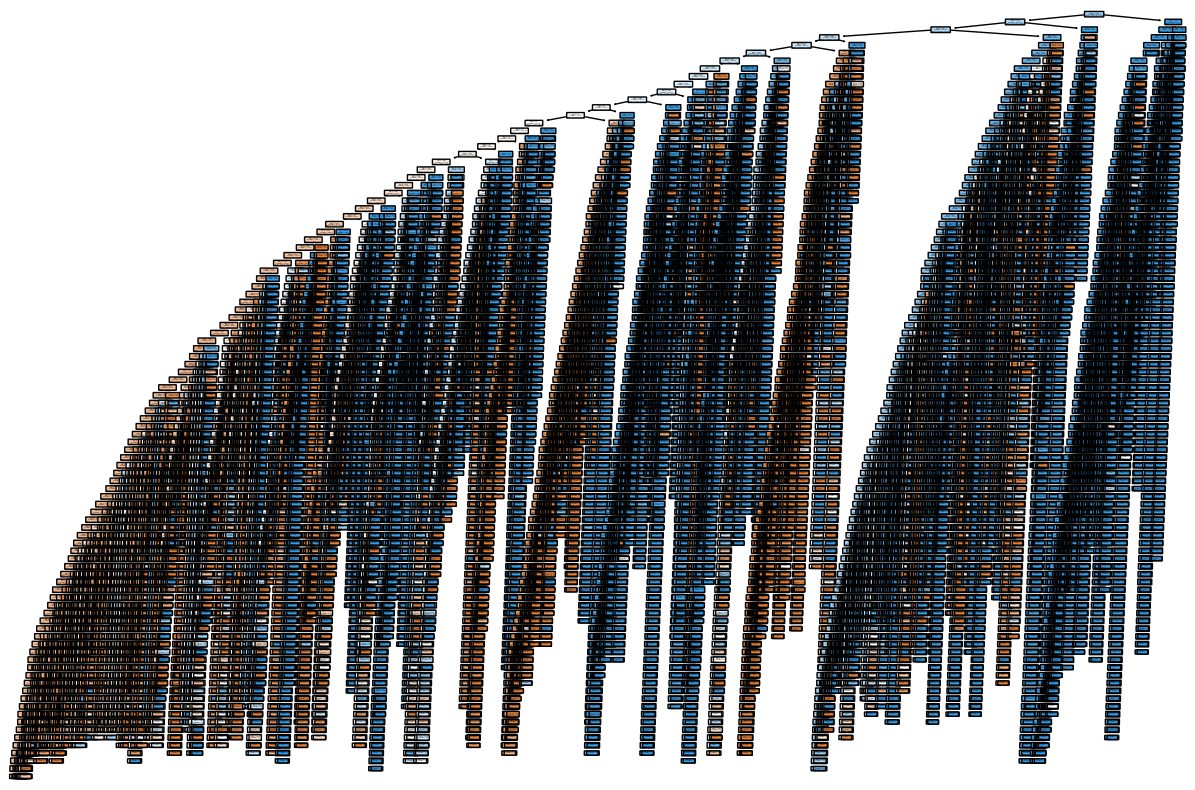

In [62]:
# a demonstration of the first decision tree out of the 200 trees

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


fig = plt.figure(figsize=(15, 10))
plot_tree(bestRFmodel.estimators_[0], 
          feature_names = X_train.columns.values.tolist(),
          # class_names=wine.target_names, 
          filled=True, impurity=True, 
          rounded=True)


[Text(0.5, 0.875, 'love <= 0.5\ngini = 0.438\nsamples = 243615\nvalue = [124778, 260495]'),
 Text(0.25, 0.625, 'beauti <= 0.5\ngini = 0.461\nsamples = 216885\nvalue = [123736, 218894]'),
 Text(0.125, 0.375, 'rt <= 0.5\ngini = 0.467\nsamples = 210284\nvalue = [123395, 208762]'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'hate <= 0.5\ngini = 0.063\nsamples = 6601\nvalue = [341, 10132]'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'happi <= 0.5\ngini = 0.048\nsamples = 26730\nvalue = [1042, 41601]'),
 Text(0.625, 0.375, 'much <= 0.5\ngini = 0.055\nsamples = 23105\nvalue = [1039, 35797]'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'guy <= 0.5\ngini = 0.001\nsamples = 3625\nvalue = [3, 5804]'),
 Text(0.8125, 0.125, '\n  (...)  \n'),
 Text(0.9375, 0.125, '\n  (...)  \n')]

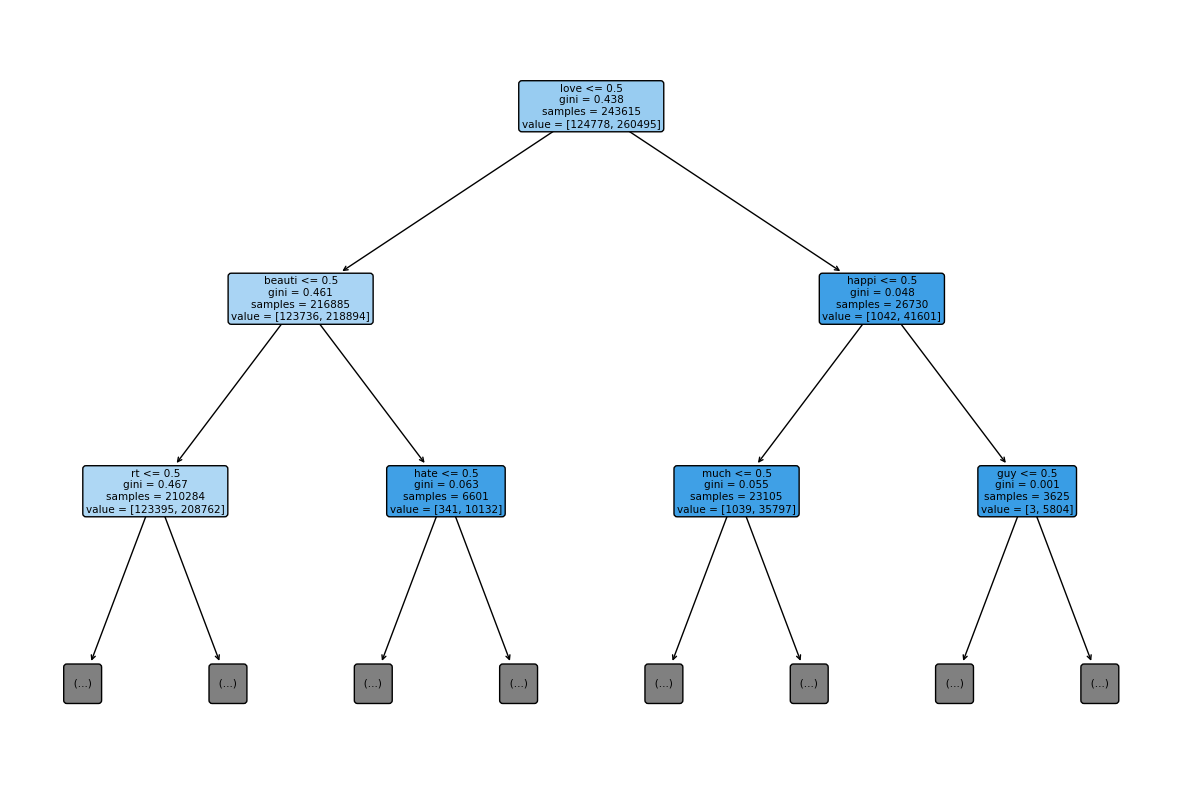

In [65]:
# a demonstration of the first 2 nodes of the first tree for visualization purpose
fig = plt.figure(figsize=(15, 10))
plot_tree(bestRFmodel.estimators_[0], 
          max_depth=2,
          feature_names = X_train.columns.values.tolist(),
          # class_names=wine.target_names, 
          filled=True, impurity=True, 
          rounded=True)


# Part 2